
# Проведение А/В - тестирования для интернет магазина.

# Приоритизация гипотез

## Задача:
- Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

## Обзор данных

В таблице `hypothesis` представленно 9 гипотез для развития бизнеса. 
Для каждой гипотезы есть оценка по 10-ти бальной шкале показателей
- охвата `reach`
- велечины оказываемого влияния `impact`
- уверенности в оценке `confidence`
- трудоемковсть выполнения `efforts`

Используем фреймворки ICE и RICE для выбора наиболее преоритетных гипотез.

In [4]:
import pandas as pd
pd.options.display.max_colwidth = 120
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import plotly.express as px

In [5]:
hypothesis = pd.read_csv(r'\hypothesis.csv')
display(hypothesis.head(10))

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [6]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts'] 
display(hypothesis[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False).round(2).head(5))

hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts'] 
display(hypothesis[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False).round(2).head(5))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00


,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2


## Выводы

- В топ-5 после использования разных фреймворков оказались гипотезы 0, 2, 6, 7, 8. 
- Однако выраженность приоритета гипотез разная у разных фреймворков. Это связано с добавлением дополнительного фактора (охвата) в расчетах. Гипотеза 8, наиболее приоритетная по ICE имеет наименьший охват и получает значительно меньшую оценку по RICE. 
- Выбор между оценками ICE и RICE в конкретных ситуациях будет зависить от актуальных целей развития и охватов продукта.
- Выбирая гипотезы для дальнейшей разработки в данном случае стоит выбрать гипотезы 
  - №7 (на 5 пунктов слабее наиболее важной по ICE, и в два раза более приоритетная чем 2 место по RICE. Имеет наибольший охват
  - №0 По результатам работы обоих фреймворков находится в топ-3. Оказывает наибольшее влияние на пользователей.

# Анализ A/B-теста

### Задачи:
 - Оценка выручки, среднего чека и конверсии по группам
 - Оценка выбросов
 - Предварительная оценка различий в группах по среднему чеку и конверсии 
 - Фильтрация результатов теста в группах А и В, оценка различий по очищенным данным
 - Вывод и принятие решения

### Обзор и подготовка данных

В таблице `orders` представленна информация о заказах из интернет-магазина.
 - transactionId — идентификатор заказа;
 - visitorId — идентификатор пользователя, совершившего заказ;
 - date — дата, когда был совершён заказ;
 - revenue — выручка заказа;
 - group — группа A/B-теста, в которую попал заказ.
 
В таблице `visitors` данные о посетителях интернет-магазина.
 - date — дата;
 - group — группа A/B-теста;
 - visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [7]:
orders = pd.read_csv(r'\orders.csv')
visitors = pd.read_csv(r'\visitors.csv')

def overview(data):
    display(data.head())
    print(data.info())
    print(f'Полностью дублированных строк: {data.duplicated().sum()}')

In [8]:
overview(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
Полностью дублированных строк: 0


In [9]:
overview(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
Полностью дублированных строк: 0


In [10]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

## Оценка выручки, среднего чека и конверсии по группам
   - Постройть график кумулятивной выручки по группам. Сделать выводы и предположения.
   - Постройть график кумулятивного среднего чека по группам. Сделать выводы и предположения.
   - Постройть график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения.
   - Постройть график кумулятивной конверсии по группам. Сделать выводы и предположения.
   - Постройть график относительного изменения кумулятивной конверсии группы B к группе A. Сделать выводы и предположения.

## Группа A

In [11]:
test_a = orders[orders['group'] == 'A'][['date', 'revenue']].reset_index(drop=True)
test_a = test_a.groupby('date', as_index=False).agg(sum_revenue=('revenue', 'sum'), count_orders=('revenue', 'count'))
test_a['cumulative_sumrevenue'] = test_a['sum_revenue'].cumsum()
test_a['mean'] = test_a['sum_revenue'] / test_a['count_orders']
test_a['cumulative_meanrevenue'] = test_a['mean'].expanding().mean()
visitors_a = visitors[visitors['group'] == 'A'][['date', 'visitors']].reset_index(drop=True)
final_a = pd.merge(test_a, visitors_a, on='date')
final_a['cumulative_countorders'] = final_a['count_orders'].cumsum()
final_a['cumulative_visitors'] = final_a['visitors'].cumsum()
final_a['cumulative_conversation'] = final_a['cumulative_countorders']/ final_a['cumulative_visitors']

## Группа B

In [12]:
test_b= orders[orders['group'] == 'B'][['date', 'revenue']].reset_index(drop=True)
test_b = test_b.groupby('date', as_index=False).agg(sum_revenue=('revenue', 'sum'), count_orders=('revenue', 'count'))
test_b['cumulative_sumrevenue'] = test_b['sum_revenue'].cumsum()
test_b['mean'] = test_b['sum_revenue'] / test_b['count_orders']
test_b['cumulative_meanrevenue'] = test_b['mean'].expanding().mean()
visitors_b = visitors[visitors['group'] == 'B'][['date', 'visitors']].reset_index(drop=True)
final_b = pd.merge(test_b, visitors_b, on='date')
final_b['cumulative_countorders'] = final_b['count_orders'].cumsum()
final_b['cumulative_visitors'] = final_b['visitors'].cumsum()
final_b['cumulative_conversation'] = final_b['cumulative_countorders']/ final_b['cumulative_visitors']

### Графики

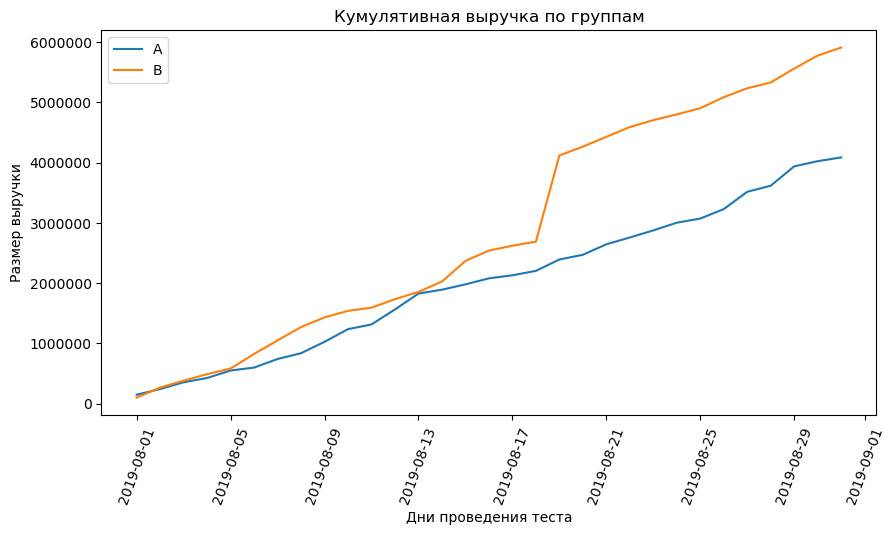

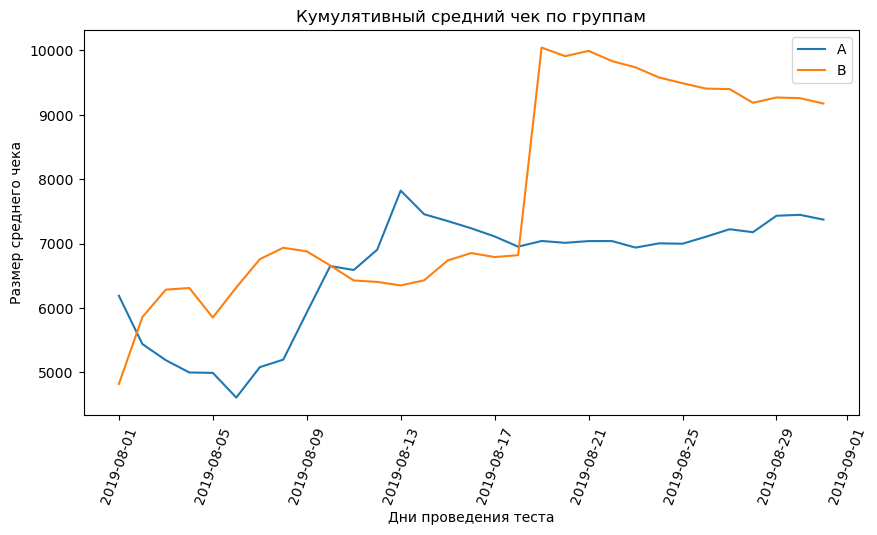

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(test_a['date'], test_a['cumulative_sumrevenue'], label='A')
plt.plot(test_b['date'], test_b['cumulative_sumrevenue'], label='B')
plt.title('Кумулятивная выручка по группам') 
plt.ylabel('Размер выручки')
plt.xlabel('Дни проведения теста')
plt.xticks(rotation=70) 
plt.ticklabel_format(style='plain', axis='y')  # Отключение научного формата по оси y
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test_a['date'], test_a['cumulative_meanrevenue'], label='A')
plt.plot(test_b['date'], test_b['cumulative_meanrevenue'], label='B')
plt.title('Кумулятивный средний чек по группам') 
plt.ylabel('Размер среднего чека')
plt.xlabel('Дни проведения теста')
plt.xticks(rotation=70) 
plt.legend()
plt.show()

**Выручка**
 - в начале проведения теста выручка в обеих группах была приблизительно равна, но с 17 августа в группе В произошел резкий скачок
 - Вторую половину теста группа В лидирует по выручке за счет скачка в кумулятивных данных

**Средний чек**
 - В начале теста средний чек в группах колеблется
 - После 17 августа, когда проишел резкий скачок выручки, наблюдается резкое увеличение среднего чека
 - После скачка данные не стабилизировались, начался спад
 
 Гипотеза: 17 августа были номально большие заказы, повлиявших на кумулятивные данные

In [14]:
cumdfA = final_a[['date', 'cumulative_sumrevenue', 'cumulative_countorders', 'cumulative_conversation']]
cumdfB = final_b[['date', 'cumulative_sumrevenue', 'cumulative_countorders', 'cumulative_conversation']]
cum_final = cumdfA.merge(cumdfB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

In [15]:
cum_final.head()

,date,cumulative_sumrevenueA,cumulative_countordersA,cumulative_conversationA,cumulative_sumrevenueB,cumulative_countordersB,cumulative_conversationB
0,2019-08-01,148579,24,0.033380,101217,21,0.029453
1,2019-08-02,242401,44,0.032885,266748,45,0.034776
2,2019-08-03,354874,68,0.036856,380996,61,0.033833
3,2019-08-04,425699,84,0.032787,489567,78,0.030315
4,2019-08-05,549917,109,0.032851,581995,101,0.030793


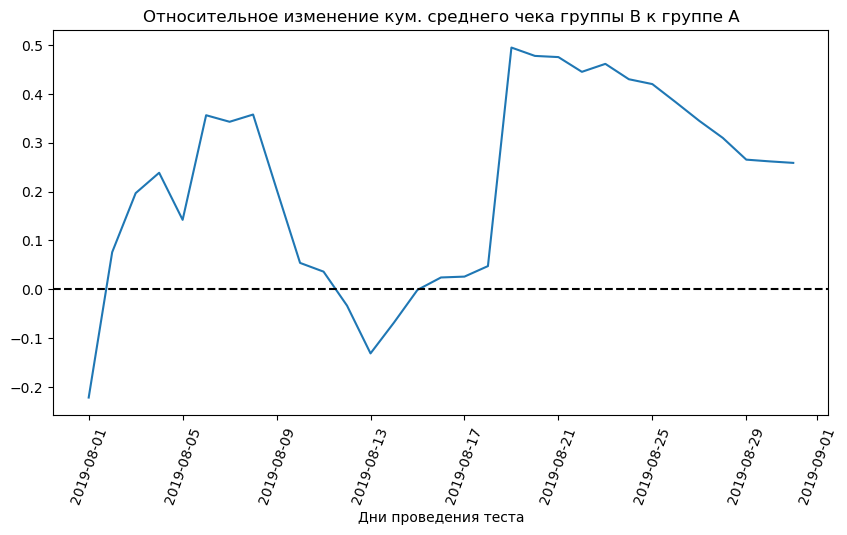

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(cum_final['date'], (cum_final['cumulative_sumrevenueB']/cum_final['cumulative_countordersB'])/(cum_final['cumulative_sumrevenueA']/cum_final['cumulative_countordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение кум. среднего чека группы В к группе А')
plt.xlabel('Дни проведения теста')
plt.xticks(rotation=70) 
plt.show()

 - Относительные изменения среднего чека в группе В колеблются
 - К середине месяца средний чек группы В резко падает и становится меньше, чем в группе A
 - После аномалии 17 августа есть резкий скачок с дальнейшим медленным спадом
 - Данные не стабилизировались. 
 
 Относительно группы А в группе В средний чек имеет некоторую тенденцию к снижению 

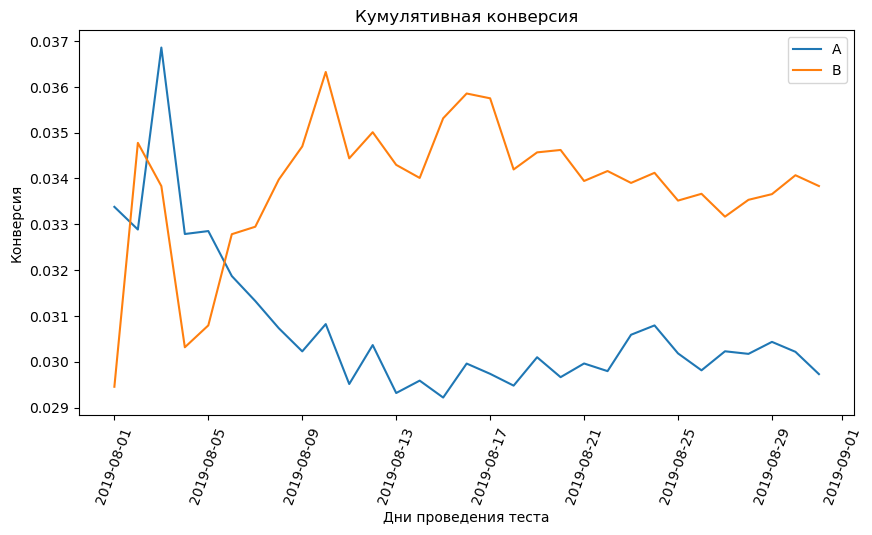

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(cum_final['date'], cum_final['cumulative_conversationA'], label='A')
plt.plot(cum_final['date'], cum_final['cumulative_conversationB'], label='B')
plt.xticks(rotation=70)
plt.title('Кумулятивная конверсия')
plt.ylabel('Конверсия')
plt.xlabel('Дни проведения теста')
plt.legend()
plt.show()

- В начале тестирования присутствуют колебания конверсии
- В 10 числах августа данные начинают стабилизироваться
- Конверсия в группе В больше, чем группе А

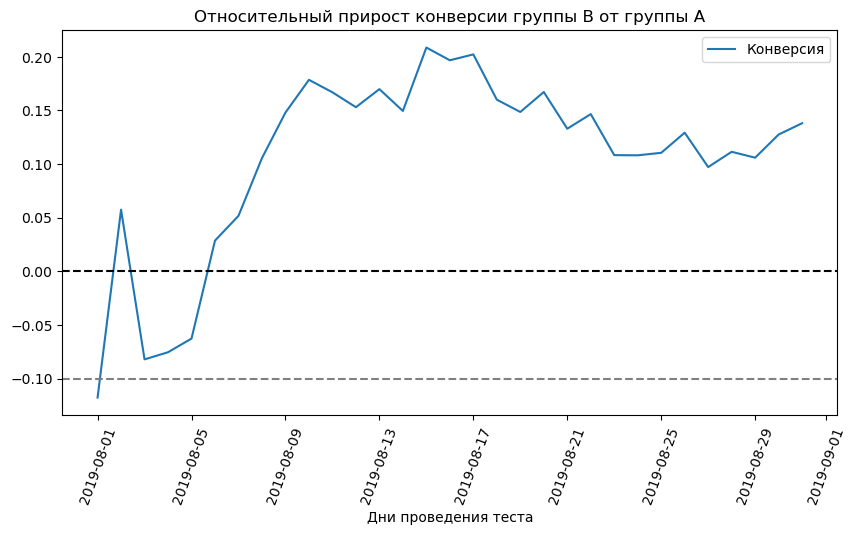

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(cum_final['date'], cum_final['cumulative_conversationB']/cum_final['cumulative_conversationA']-1, label='Конверсия')
plt.title('Относительный прирост конверсии группы B от группы A')
plt.xlabel('Дни проведения теста')
plt.xticks(rotation=70) 
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.show()

- После флуктуаций в начале теста конверсия в группе В растет и стабилизируется
- По оценке графика можно предполагать, что в группе В конверсия может быть на 10-20% больше 

## Оценка выбросов
 - Построить гистрограмму количества заказов по пользователям. Сделать выводы и предположения.
 - Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.
 - Построить точечный график стоимостей заказов. Сделать выводы и предположения.
 - Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.

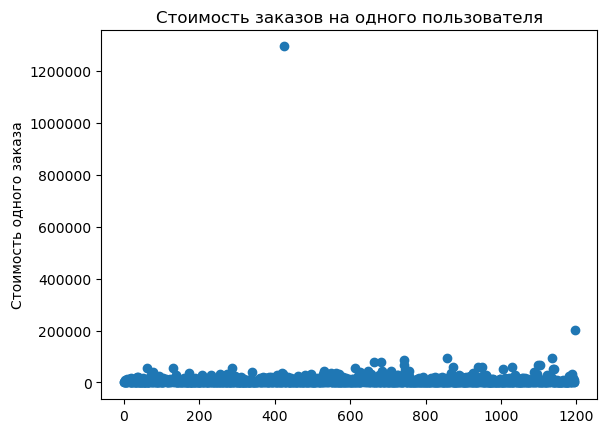

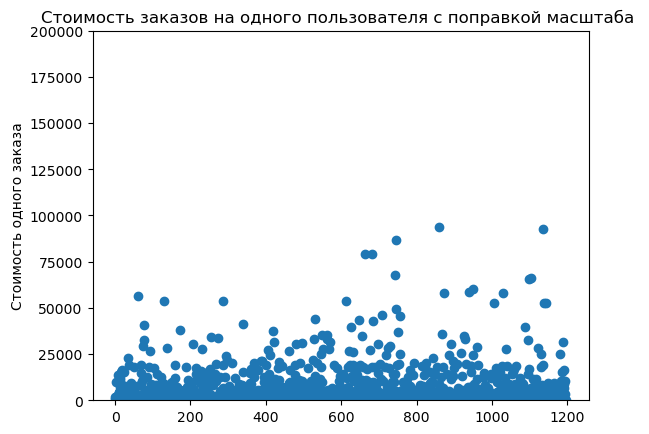

In [19]:
#display(orders.head())

#
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ticklabel_format(style='plain', axis='y')
plt.title('Стоимость заказов на одного пользователя')
plt.ylabel('Стоимость одного заказа')
plt.show()
#Есть сверхдорогие заказы дороже 200 тысяч и один даже дороже миллиона, но оставшиеся заказы сливаются в линию ниже 100000


x_values = pd.Series(range(0, len(orders['revenue'])))
plt.ylim(0, 200000)
plt.scatter(x_values, orders['revenue'])
plt.ticklabel_format(style='plain', axis='y')
plt.title('Стоимость заказов на одного пользователя с поправкой масштаба ')
plt.ylabel('Стоимость одного заказа')
plt.show()

In [20]:
orders_per_users = orders.groupby('visitorId', as_index=False)['transactionId'].count()
orders_per_users = orders_per_users.rename(columns = {'transactionId' : 'orders_per'})

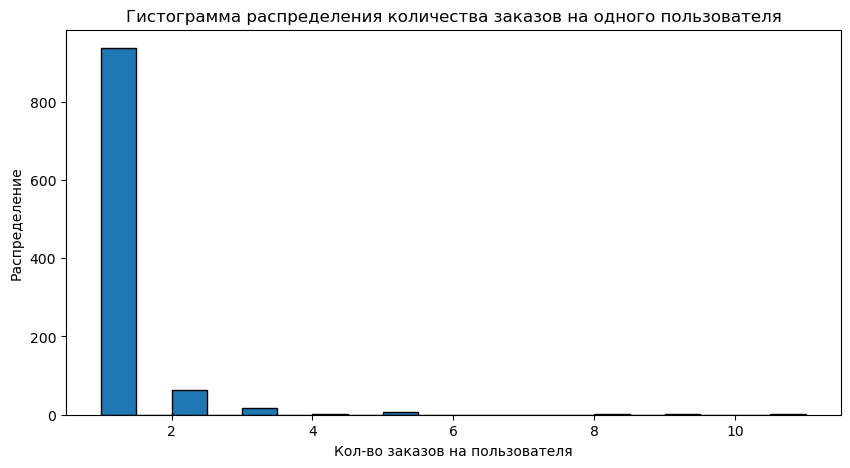

In [45]:
plt.figure(figsize=(10, 5))

# Создание гистограммы
plt.hist(orders_per_users['orders_per'], bins=20, edgecolor='black')

# Настройка меток и заголовка
plt.xlabel('Кол-во заказов на пользователя')
plt.ylabel('Распределение')
plt.title('Гистограмма распределения количества заказов на одного пользователя')

# Настройка размеров графика
# plt.gcf().set_size_inches(11, 4)  # ширина 11 дюймов, высота 4 дюйма

# Отображение графика
plt.show()

# **Стоимость заказа**
- На графике по всем данным сложно делать выводы. Можно указать два сверходорогих заказа, остальные данные сливаются.
- Отсечем эти аномалии с графика изменив масштаб. Видно, что большая часть заказов в основном ниже отметки в 20-25 тысяч 

**Количество заказов**
- Чаще всего покупают 1 или 2 раза, но есть пользователи, совершившие и 11 заказов.

In [22]:
print('95 и 99 перцентили для стоимости заказов:', np.percentile(orders['revenue'], [95, 99]))
print('95 и 99 перцентели для количества заказов на одного пользователя:', np.percentile(orders_per_users['orders_per'], [95, 99]))

95 и 99 перцентили для стоимости заказов: [28000.  58233.2]
95 и 99 перцентели для количества заказов на одного пользователя: [2. 4.]


**Граница аномальных данных**
- Примем за выбросы по 5% данных от максимальных.
- Таким образом, граница для стоимости заказа будет 28 тысяч, а для количества заказов на пользователя - не больше 2

##  Предварительная оценка различий в группах по среднему чеку и конверсии 
- Посчитать статистическую значимость различий в конверсии между группами по «сырым» данным. Сделать выводы и предположения.
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и предположения.


## Гипотезы 

В тесте для двух несвязанных выборок будем оценивать статистическую значимость между группами U- критерием Манна-Уитни. Проведем оценку различий по следующим показателям:
1. Конверсия
2. Средний чек.

Для каждой проверки будут следующие гипотезы:
 - H0 Между группами А и В нет различий по оцениваемому показателю.
 - H1 Между группами А и В есть различия по оцениваемому показателю. 
 
При наличии статистически значимых различий их отношения (в какой группе показатель больше) оценивается по относительной разнице этого показателя группы В к группе А.

In [23]:

visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']].rename(columns = {'visitors' : 'visitorsPerDateA'})
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']].rename(columns = {'visitors' : 'visitorsPerDateB'})


ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : 'nunique'})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : 'nunique'})
ordersByUsersB.columns = ['userId', 'orders']


sampleA = pd.concat(
    [ordersByUsersA['orders'], 
     pd.Series(0, index=np.arange(visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
               name='orders')],axis=0)

sampleB = pd.concat(
    [ordersByUsersB['orders'],
     pd.Series(0, index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
               name='orders')],axis=0)

In [24]:
print('p-value различий в конверсии между группами А и В =', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB).pvalue))
print('Относительная разница конверсии группы В по отношению к группе А =',"{0:.1%}".format(sampleB.mean()/sampleA.mean()-1))

p-value различий в конверсии между группами А и В = 0.017
Относительная разница конверсии группы В по отношению к группе А = 13.8%


**Сырые различия по конверсии**
- Между группами есть статистически значимые различия.
- Конверсия в группе В больше на 13.8% процентов.

In [25]:
print('p-value различий в среднем чеке между группами А и В =',"{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительная разница среднего чека группы В по отношению к группе А =',"{0:.1%}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value различий в среднем чеке между группами А и В = 0.729
Относительная разница среднего чека группы В по отношению к группе А = 25.9%


**Средний чек по сырым данным**
 - Между группами нет значимых различий
 - Но в сырых данных есть значения о том, что в группе В чек больше на 25%. 
 
 Так как относительный рост среднего чека на четверть в группе В не считаем статистически значимым, проведем анализ без аномалий. Зафиксированный на графиках скачок 17 августа мог повлиять на этот показатель. Стоит проверить, будут ли группы все еще не различаться без учета сверх-дорогих заказов.

## Фильтрация результатов теста в группах А и В, оценка различий по очищенным данным
- Посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделать выводы и предположения.
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения.

## Гипотезы 

На данном этапе проводим перепроверку оценки различий между группами, аналогичную предыдущей, но не учитываем аномальные данные.
В тесте для двух несвязанных выборок будем оценивать статистическую значимость между группами U- критерием Манна-Уитни. Проведем оценку различий по следующим показателям:
1. Конверсия
2. Средний чек.

Для каждой проверки будут следующие гипотезы:
 - H0 Между группами А и В нет различий по оцениваемому показателю.
 - H1 Между группами А и В есть различия по оцениваемому показателю. 
 
При наличии статистически значимых различий их отношения (в какой группе показатель больше) оценивается по относительной разнице этого показателя группы В к группе А.

In [26]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 4]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print('Количество аномальных пользователей', abnormalUsers.shape)

Количество аномальных пользователей (68,)


In [27]:
sampleAFiltered = pd.concat(
    [ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
     pd.Series(0, index=np.arange(visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],
    axis=0)

sampleBFiltered = pd.concat(
    [ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
     pd.Series(0, index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],
    axis=0)

In [28]:
print('p-value различий в конверсии между группами А и В (без аномалий) =', "{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительная разница в конверсии группы В к А (без аномалий) =',"{0:.1%}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value различий в конверсии между группами А и В (без аномалий) = 0.011
Относительная разница в конверсии группы В к А (без аномалий) = 20.4%


**Конверсия**
 - В группе В конверсия все еще статистически значимо больше, чем в группе А
 - Относительный прирост составляет 20%

In [29]:
print('p-value различий в среднем чеке между группами А и В (без аномалий)',"{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print('Относительная разница среднего чека в группе В к А (без аномалий)',"{0:.1%}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

p-value различий в среднем чеке между группами А и В (без аномалий) 0.789
Относительная разница среднего чека в группе В к А (без аномалий) -1.7%


**Средний чек**
- После удаления из данных аномально дорогих заказов относительная разница среднего чека уменьшилась, хотя по сырым данным в группе В чек был на 25% процентов больше
- Таким образом, относительный прирост в 25% от группы А был обусловлен 5% сверхдорогих заказов, случившихся предположительно 17 августа
- По среднему чеку в группах А и В нет статистических различий

# Вывод и принятие решения по результатам тестирования
   
   - Конверсия в группе В значимо больше, чем в группе А
     -  условия, представленные группе В значимо увеличивают конверсию, способствуют совершению заказа.
   - По среднему чеку значимых различий не зафиксировано
   - Средний чек в группе В не успел стабилизироваться из-за аномалий, возникших в середине тестирования
   
### Тест следует прожолжить.
 - Дать возможность среднему чеку стабилизироваться в группах
 - Не смотря на имеющиеся выводы о конверсии в группах, это возможность проверить в долгосрочной перспективе бОльшую конверсию группы В - останутся ли показатели на том же уровне, или сработал некий фактор новизны
  

# Общий вывод

В работе была проведена приоритезация 9-тигипотез для дальнейшего тестирования.

 - Были применены фреймворки ICE и RICE.
 - Фреймворки по разному ранжируют приоритет гипотезы из-за особенностей расчета оценки.
 - RICE выделяет наиболее приоритетные гипотезы с учетом охвата пользователей, которых затронет изменение.
 - Выбор решающей системы оценки гипотез зависит от целей компании на данный момент и особенностей бизнеса. Для каждой системы выделены топ-3 приоритетных гипотез.
 - Выбирая гипотезы сбалансированно между фреймворками ICE и RICE для дальнейшей работы подходят гипотезы № 7 или № 0.
 
Анализ результатов проведенного А/В тестирования.
1. Расчет кумулятивных показателей.
   - Конверсия в группах стабилизировалась, на графиках виден больший рост конверсии в группе В. График относительных изменений подтверждает это.
   - Выручка и средний чек соответственно не стабилизировались до конца. По графикам можно говорить о росте показателей для группы В, но так же видна серьезная аномалия, произошедшая в середине тестирования. Этот фактор надо учитывать, как способный исказить результаты.
   
   
2. Сравнение выбранных метрик (конверси и средний чек) в группах
   - Разница между группами по конверсии статистически значимая, в группе В конверсия на 14% больше.
   - Разница в отношении среднего чека статистически незначимая, ни одна из групп не заработала "больше" за оцениваемый период, хотя расчет относительных различий показывает, что в группе В средний чек больше на 25%. Необходим анализ аномалий.
   
   
3. Анализ аномальных значений в данных.
   - На графиках рассеивания заметно некоторое количество точек-аномалий, небольшого количества сверхбольших значений для выбранных метрик. Это как слишком большое количество заказов на одного покупателя, так и сверхдорогие заказы. Для обеих метрик аномалии могли повлиять на расчет различий.
   - После выделения перцентелей для обеих метрик мы отсекли по 5% самых данных.
   
   
4. Сравнение метрик в очищенных данных.
   - После очистки данных конверсия в группах статистически отличается. Расчет относительных показателей показывает, что в группе В конверсия на 20% больше.
   - В отношении среднего чека все еще нет значимых различий, а относительные показатели стали показывать, что группа Б заработала на 1.7% меньше без учета сверхдорогих заказов.
   
   
Считаю, что тест необходимо продолжать для стабилизации показателей среднего чека и выручки.